In [215]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This tutorial shows how to use an MMContext Sentence Transformers model. It assumes you created a huggingface dataset, which contains the cell representations (either cell ids for numerical embeddings or cell sentences for text_only usage). Such datasets can be created with a pipeline available through the https://github.com/mengerj/adata_hf_datasets repo. If you instead want to start from an adata object, see the tutorial pretrained_inference.ipynb

In [ ]:
import pandas as pd
from datasets import load_dataset

repo_name = "jo-mengr"
dataset_name = "human_immune_health_atlas_50k_normlog_single_no_caption"
split_name = "test"
label_key = "AIFI_L2"
batch_key = "batch_id"

In [217]:
dataset = load_dataset(f"{repo_name}/{dataset_name}")
test_dataset = dataset[split_name]

In [218]:
from sentence_transformers import SentenceTransformer

model_name = "jo-mengr/mmcontext-pubmedbert-geneformer-cxg"
model = SentenceTransformer(model_name, trust_remote_code=True)
data_type = "geneformer"
layer_key = f"X_{data_type}"
text_only = False
primary_cell_sentence = "cell_sentence_1"  # set to cell_sentence_2 for text based models

Loaded encoder was registered for 'geneformer' data. Call register_initial_embeddings() with compatible data before using it.


In [219]:
from dotenv import load_dotenv

load_dotenv()

True

In [220]:
import os

from mmcontext.file_utils import load_test_adata_from_hf_dataset, subset_dataset_by_chunk

link_column = "share_link" if "share_link" in test_dataset.column_names else "adata_link"
adata, local_path = load_test_adata_from_hf_dataset(
    test_dataset,
    save_dir=f"../data/from_nxtcloud/{dataset_name}",
    link_column=link_column,
    zenodo_token=os.getenv("ZENODO_TOKEN"),
)
adata, dataset_sub = subset_dataset_by_chunk(adata, test_dataset)

Processing:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer-v1' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_gs10k' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [221]:
if not text_only:
    token_df, _ = model[0].get_initial_embeddings_from_adata_link(
        dataset_sub,
        layer_key=layer_key,
        download_dir=f"../data/from_nxtcloud/{dataset_name}",
        axis="obs",
        link_column=link_column,
    )
    model[0].register_initial_embeddings(token_df, data_origin=data_type)

Processing:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer-v1' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_gs10k' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)


Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


In [222]:
from datasets import DatasetDict

from mmcontext.utils import truncate_cell_sentences

# enc.register_initial_embeddings(token_df, data_origin="geneformer")
if not text_only:
    dataset_ready = model[0].prefix_ds(dataset_sub, primary_cell_sentence)
else:
    dataset_split = truncate_cell_sentences(
        dataset_sub[split_name], primary_cell_sentence, max_length=64, filter_strings=["RPS", "RPL", "MT"]
    )
    dataset_ready = DatasetDict({split_name: dataset_split})

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Prefixing columns: ['cell_sentence_1']:   0%|          | 0/33479 [00:00<?, ? examples/s]

In [223]:
dataset_to_use = dataset_ready  # [split_name]

In [224]:
dataset_to_use[0]

{'sample_idx': '10f27ae2671711ed94878208818934b6',
 'cell_sentence_1': 'sample_idx:10f27ae2671711ed94878208818934b6',
 'cell_sentence_2': 'MALAT1 IGLC2 RPS12 RPS27 RPS18 RPS8 RPS4X RPL30 RPL32 CD74 RPS27A RPS3A HLA-DRA RPS29 MT-CO1 MT-CO2 ACTB RPS6 B2M TMSB4X RPL21 CD37 MT-CO3 MT-ND3 LTB RPS3 HLA-DRB1 FTL RPS26 MT-CYB HLA-DPA1 TCL1A IGHM HLA-DPB1 MT-ATP6 HLA-DQB1 FTH1 PDLIM1 MEF2C MBD4 BANK1 HLA-DQA1 NCF1 FAM133B MS4A1 IGHD PRKCB CD79B AC243960.1 CD79A POU2F2 IGLC3 RERE EIF4G3 C1orf56 KIAA0040 UBE2T CXCR4 TMEM156 CFAP97 SREK1IP1 SNX2 CXXC5 HIST1H1D CLIC1 HLA-DRB5 FGD2 ZNF318 RP9 ZNF107 PLEKHF2 TTF1 CD81 SWAP70 CYB561A3 GSTP1 RAB30 BIRC3 NOLC1 AC025164.1 C12orf42 AL139020.1 ZNF106 RNF111 FAM129C VPREB3 FAM207A AL450998.2 BX284668.5 SH3BGRL3 TUT4 JUN AC093157.1 PTPN22 CD2 HIST2H2BF PLEKHO1 S100A6 CKS1B FCRL2 FCRL1 TAGLN2 FCRLA RALGPS2 BTG2 PIK3C2B FCMR CD55 LYPLAL1 CHML ROCK2 TRIB2 CCDC88A CAPG ZNF514 AFF3 MRPS9 KYNU ZEB2 PMS1 TRNT1 SH3BP5 ZNF860 IP6K2 TCTA RASSF1 APPL1 DENND6A FOXP1 NFK

In [225]:
text_encoder_name = model[0].text_encoder_name
text_encoder = SentenceTransformer(text_encoder_name)

In [226]:
modified_labels = [f"{label}" for label in adata.obs[label_key].values.tolist()]
# extend list by some aritifial labels
# modified_labels.extend(["human cell","neuron","apple","car"])
# get unique labels from the list
modified_labels = list(set(modified_labels))
modified_labels

['pDC',
 'CD56bright NK cell',
 'cDC1',
 'DN T cell',
 'Treg',
 'gdT',
 'Naive CD8 T cell',
 'Intermediate monocyte',
 'CD14 monocyte',
 'Platelet',
 'Memory CD4 T cell',
 'CD56dim NK cell',
 'Naive B cell',
 'ILC',
 'Naive CD4 T cell',
 'ASDC',
 'Memory B cell',
 'Plasma cell',
 'CD8aa',
 'Proliferating NK cell',
 'Proliferating T cell',
 'Progenitor cell',
 'Effector B cell',
 'Transitional B cell',
 'CD16 monocyte',
 'cDC2',
 'Memory CD8 T cell',
 'MAIT']

In [227]:
omics_embeddings = model.encode(dataset_to_use[primary_cell_sentence])

In [228]:
dataset_to_use

Dataset({
    features: ['sample_idx', 'cell_sentence_1', 'cell_sentence_2', 'adata_link'],
    num_rows: 33479
})

In [229]:
omics_embeddings = model.encode(dataset_to_use[primary_cell_sentence])
adata.obsm["mmcontext_emb"] = omics_embeddings

<Figure size 800x800 with 0 Axes>

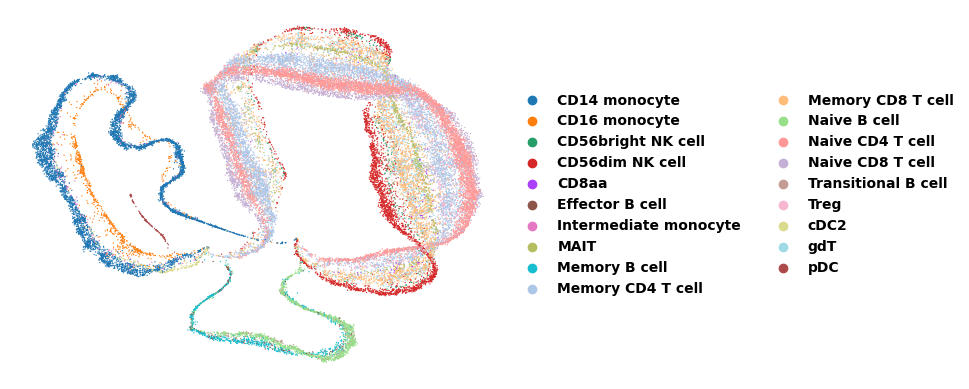

In [230]:
# Visualise the embeddings
from mmcontext.pl import plot_umap
from mmcontext.utils import consolidate_low_frequency_categories

current_key = label_key
adata_cut = consolidate_low_frequency_categories(adata, [current_key], threshold=50, remove=True)
emb_key = "mmcontext_emb"
plot_umap(
    adata,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

<Figure size 800x800 with 0 Axes>

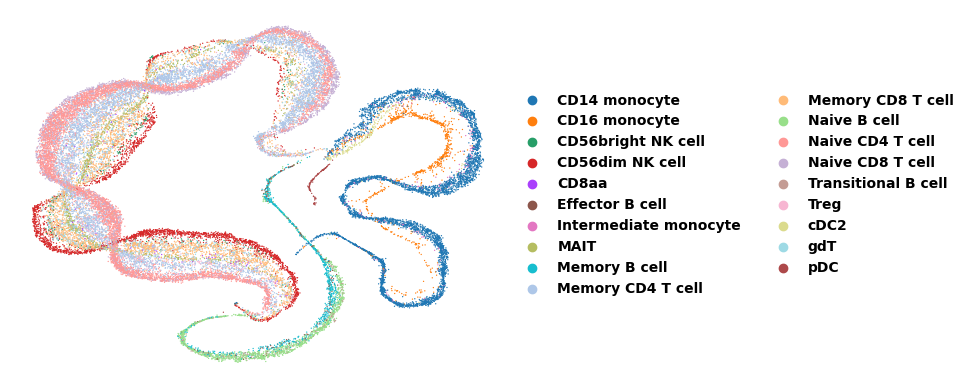

In [231]:
# Visualise the embeddings
from mmcontext.pl import plot_umap
from mmcontext.utils import consolidate_low_frequency_categories

current_key = label_key
adata_cut = consolidate_low_frequency_categories(adata, [current_key], threshold=1, remove=False)
emb_key = layer_key
plot_umap(
    adata_cut,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    nametag="",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

In [232]:
from mmcontext.eval import get

EvClass = get("LabelSimilarity")
ev = EvClass(
    auto_filter_labels=False,
    umap_n_neighbors=15,
    umap_min_dist=0.5,
    similarity="cosine",
    logit_scale=1,
    score_norm_method=None,
)

In [233]:
# precompute umap coordinates to reuse on subset
full_omics_embeddings = adata.obsm["mmcontext_emb"]

In [234]:
# full_cell_umap = ev._compute_umap(full_omics_embeddings)
# add umap coordinates to adata
# adata.obsm["cell_umap"] = full_cell_umap

In [235]:
full_query_labels = adata.obs[label_key].unique().tolist()
full_label_embeddings = model.encode(full_query_labels)
full_true_labels = adata.obs[label_key]

In [236]:
from pathlib import Path

result = ev.compute(
    omics_embeddings=full_omics_embeddings,
    label_embeddings=full_label_embeddings,
    query_labels=full_query_labels,
    true_labels=full_true_labels,
    label_key=label_key,
    out_dir=Path(f"LabelSimilarity/{model_name}/{dataset_name}"),  # Pass output directory for caching
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)


In [237]:
result

CD14 monocyte/auc: 0.9078
CD14 monocyte/accuracy: 0.2124
CD16 monocyte/auc: 0.6317
CD16 monocyte/accuracy: 0.1400
CD56bright NK cell/auc: 0.9710
CD56bright NK cell/accuracy: 0.0147
CD56dim NK cell/auc: 0.9685
CD56dim NK cell/accuracy: 0.0000
CD8aa/auc: 0.8270
CD8aa/accuracy: 0.0000
Effector B cell/auc: 0.8350
Effector B cell/accuracy: 0.1854
Intermediate monocyte/auc: 0.8913
Intermediate monocyte/accuracy: 0.4513
MAIT/auc: 0.5897
MAIT/accuracy: 0.0000
Memory B cell/auc: 0.9439
Memory B cell/accuracy: 0.1088
Memory CD4 T cell/auc: 0.7730
Memory CD4 T cell/accuracy: 0.5830
Memory CD8 T cell/auc: 0.7406
Memory CD8 T cell/accuracy: 0.7373
Naive B cell/auc: 0.9500
Naive B cell/accuracy: 0.0000
Naive CD4 T cell/auc: 0.8677
Naive CD4 T cell/accuracy: 0.1200
Naive CD8 T cell/auc: 0.7347
Naive CD8 T cell/accuracy: 0.6763
Transitional B cell/auc: 0.9287
Transitional B cell/accuracy: 0.0476
Treg/auc: 0.7856
Treg/accuracy: 0.0483
cDC2/auc: 0.7026
cDC2/accuracy: 0.4405
gdT/auc: 0.6760
gdT/accuracy:

In [190]:
ev.plot(
    omics_embeddings=full_omics_embeddings,
    # cell_umap=full_cell_umap,
    out_dir=Path(f"LabelSimilarity/{model_name}/{dataset_name}/{label_key}_combined"),
    label_embeddings=full_label_embeddings,
    query_labels=full_query_labels,
    true_labels=full_true_labels,
    label_key=label_key,  # column name (e.g. "celltype")
    save_format="png",
    figsize=(4, 4),
    dpi=600,
    font_size=12,
    font_style="normal",
    font_weight="normal",
    legend_fontsize=54,
    axis_label_size=20,
    axis_tick_size=12,
    point_size=0.5,
    legend_layout="vertical",
    legend_point_size=20,
    text_dot_fill_color="black",
    text_dot_edge_color="label",
    text_dot_alpha=0.2,
    umap_method="combined",
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/mengerj/repos/mmcontext/src/mmcontext/e

In [ ]:
# Option to subset adata based on one or more label values (e.g., "Monocyte" and "DC")
subset_label_values = ["T cell"]  # Change this list to your desired label values
subset_label_key = "AIFI_L1"
annotation_label_key = "AIFI_L2"
# Subset the AnnData object for any of the specified label values
adata_subset = adata[adata.obs[subset_label_key].isin(subset_label_values)].copy()
subset_labels = adata_subset.obs[annotation_label_key].values.unique()
label_embeddings_subset = model.encode(subset_labels)
# Create a new LabelSimilarity evaluator instance
# ev_subset = EvClass(auto_filter_labels=False, umap_n_neighbors=15, umap_min_dist=0.5)
subset_label_string = "_".join(subset_label_values)
subset_omics_embeddings = adata_subset.obsm["mmcontext_emb"]
subset_umap_coords = adata_subset.obsm["cell_umap"]
# ev_subset.eb_lfdr_q = 0.01
# Compute metrics on the subsetted data
result_subset = ev.compute(
    omics_embeddings=subset_omics_embeddings,
    label_embeddings=label_embeddings_subset,
    query_labels=subset_labels,
    true_labels=adata_subset.obs[annotation_label_key],
    label_key=annotation_label_key,
    out_dir=Path(
        f"LabelSimilarity/{model_name}/{dataset_name}/{annotation_label_key}_subset_{subset_label_string}/results"
    ),
)

# Plot results for the subset
ev.plot(
    omics_embeddings=subset_omics_embeddings,
    #    cell_umap=subset_umap_coords,
    out_dir=Path(
        f"LabelSimilarity/{model_name}/{dataset_name}/{annotation_label_key}_subset_{subset_label_string}_combined"
    ),
    label_embeddings=label_embeddings_subset,
    query_labels=subset_labels,
    true_labels=adata_subset.obs[annotation_label_key],
    label_key=annotation_label_key,
    save_format="png",
    figsize=(4, 4),
    dpi=600,
    font_size=12,
    axis_tick_size=12,
    font_style="normal",
    font_weight="normal",
    legend_fontsize=54,
    axis_label_size=20,
    point_size=0.5,
    legend_layout="vertical",
    legend_point_size=20,
    text_dot_fill_color="black",
    text_dot_edge_color="label",
    text_dot_alpha=0.4,
    umap_method="combined",
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: divide by zero encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: overflow encountered in matmul
  return (emb1_norm @ emb2_norm.T).astype(np.float32)
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/label_similarity.py:76: RuntimeWarning: invalid value enco

In [58]:
result_subset

CD8aa/auc: 0.7795
CD8aa/accuracy: 0.0291
DN T cell/auc: 0.4212
DN T cell/accuracy: 0.0263
MAIT/auc: 0.9133
MAIT/accuracy: 0.1647
Memory CD4 T cell/auc: 0.8883
Memory CD4 T cell/accuracy: 0.5637
Memory CD8 T cell/auc: 0.9343
Memory CD8 T cell/accuracy: 0.5164
Naive CD4 T cell/auc: 0.7709
Naive CD4 T cell/accuracy: 0.9013
Naive CD8 T cell/auc: 0.9552
Naive CD8 T cell/accuracy: 0.8054
Proliferating T cell/auc: 0.9625
Proliferating T cell/accuracy: 0.8889
Treg/auc: 0.9082
Treg/accuracy: 0.6193
gdT/auc: 0.7833
gdT/accuracy: 0.3079
mean_auc: 0.8317
std_auc: 0.1536
accuracy: 0.6640
balanced_accuracy: 0.4823
random_baseline_accuracy: 0.1000
accuracy_over_random: 6.6397
n_labels: 10

In [ ]:
from mmcontext.eval.query_annotate import OmicsQueryAnnotator

annotator = OmicsQueryAnnotator(model)
annotator.annotate_omics_data(adata, modified_labels, emb_key="mmcontext_emb")

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: divide by zero encountered in matmul
  similarity_matrix = data_emb @ label_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: overflow encountered in matmul
  similarity_matrix = data_emb @ label_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: invalid value encountered in matmul
  similarity_matrix = data_emb @ label_emb.T


In [163]:
# get accuracy of best label vs true label
from sklearn.metrics import accuracy_score

accuracy_score(adata.obs["best_label"], adata.obs[label_key])

0.42632695122315484

In [159]:
if dataset_name == "human_immune_health_atlas_50k_single_no_caption":
    df = pd.read_csv("../../data/queries/additional_combined.csv")
    labels = df["Cell Type"]
    Definition = df["Definition"]
    from mmcontext.eval.query_annotate import OmicsQueryAnnotator
    from mmcontext.pl.plotting import plot_query_scores_with_labels_umap

    annotator = OmicsQueryAnnotator(model)
    annotator.query_with_text(adata, Definition, emb_key="mmcontext_emb")
    # Call the plotting function
    plot_query_scores_with_labels_umap(
        adata=adata,
        queries=Definition,
        labels=labels,
        label_key="AIFI_L2",
        save_dir=f"figs/{model_name}/{dataset_name}/umap_with_labels",
        nametag="",
        figsize=(4, 4),
        point_size=2,
        dpi=300,  # Lower DPI for faster generation
        axis_label_size=18,
        axis_tick_size=18,
    )

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:179: RuntimeWarning: divide by zero encountered in matmul
  similarity_matrix = query_emb @ data_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:179: RuntimeWarning: overflow encountered in matmul
  similarity_matrix = query_emb @ data_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:179: RuntimeWarning: invalid value encountered in matmul
  similarity_matrix = query_emb @ data_emb.T
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [79]:
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(
    adata,
    embedding_dict={"omics": "mmcontext_emb", "text": "mmcontext_text_emb"},
    subset_size=20,
    label_keys=[batch_key, label_key],
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:208: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[label_key] = adata.obs[label_key][sampled_indices[idx]]


Requested n_samples (50) is greater than total unique sample_ids (20). Using all sample_ids instead.
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 6000x6000 with 0 Axes>

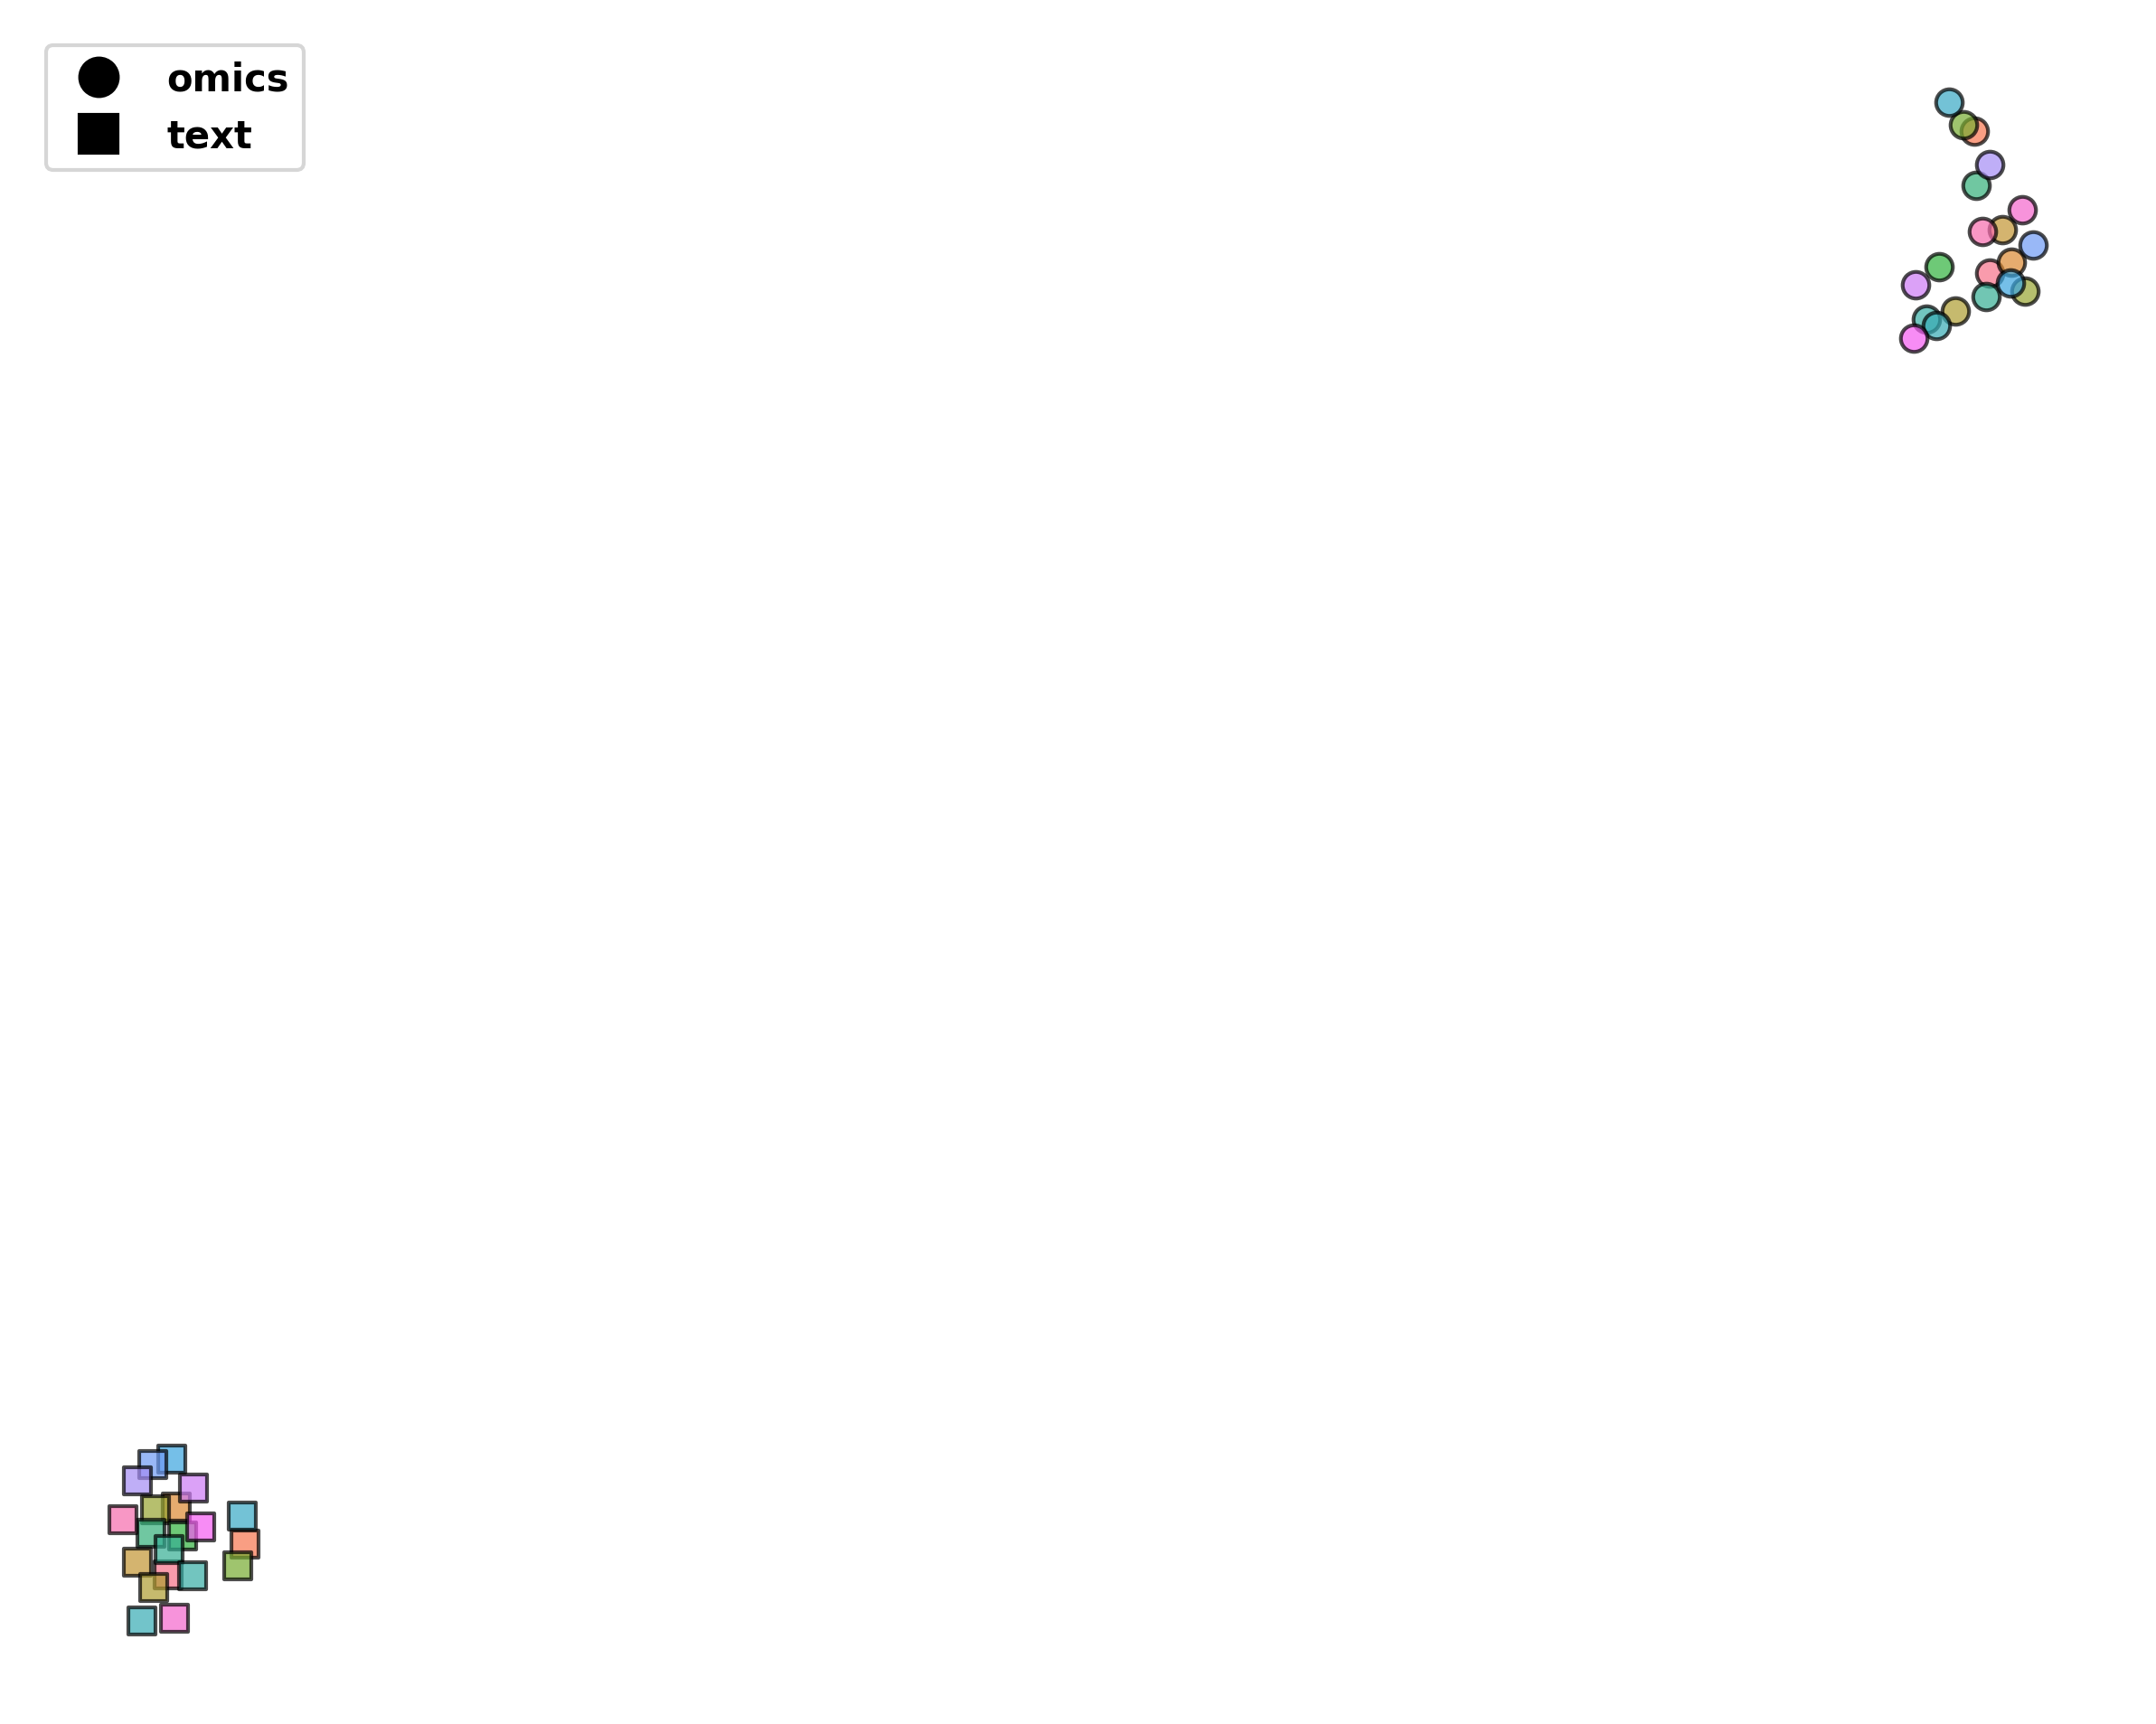

In [58]:
from mmcontext.pl import visualize_embedding_clusters

visualize_embedding_clusters(emb_pair_df, method="umap", metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


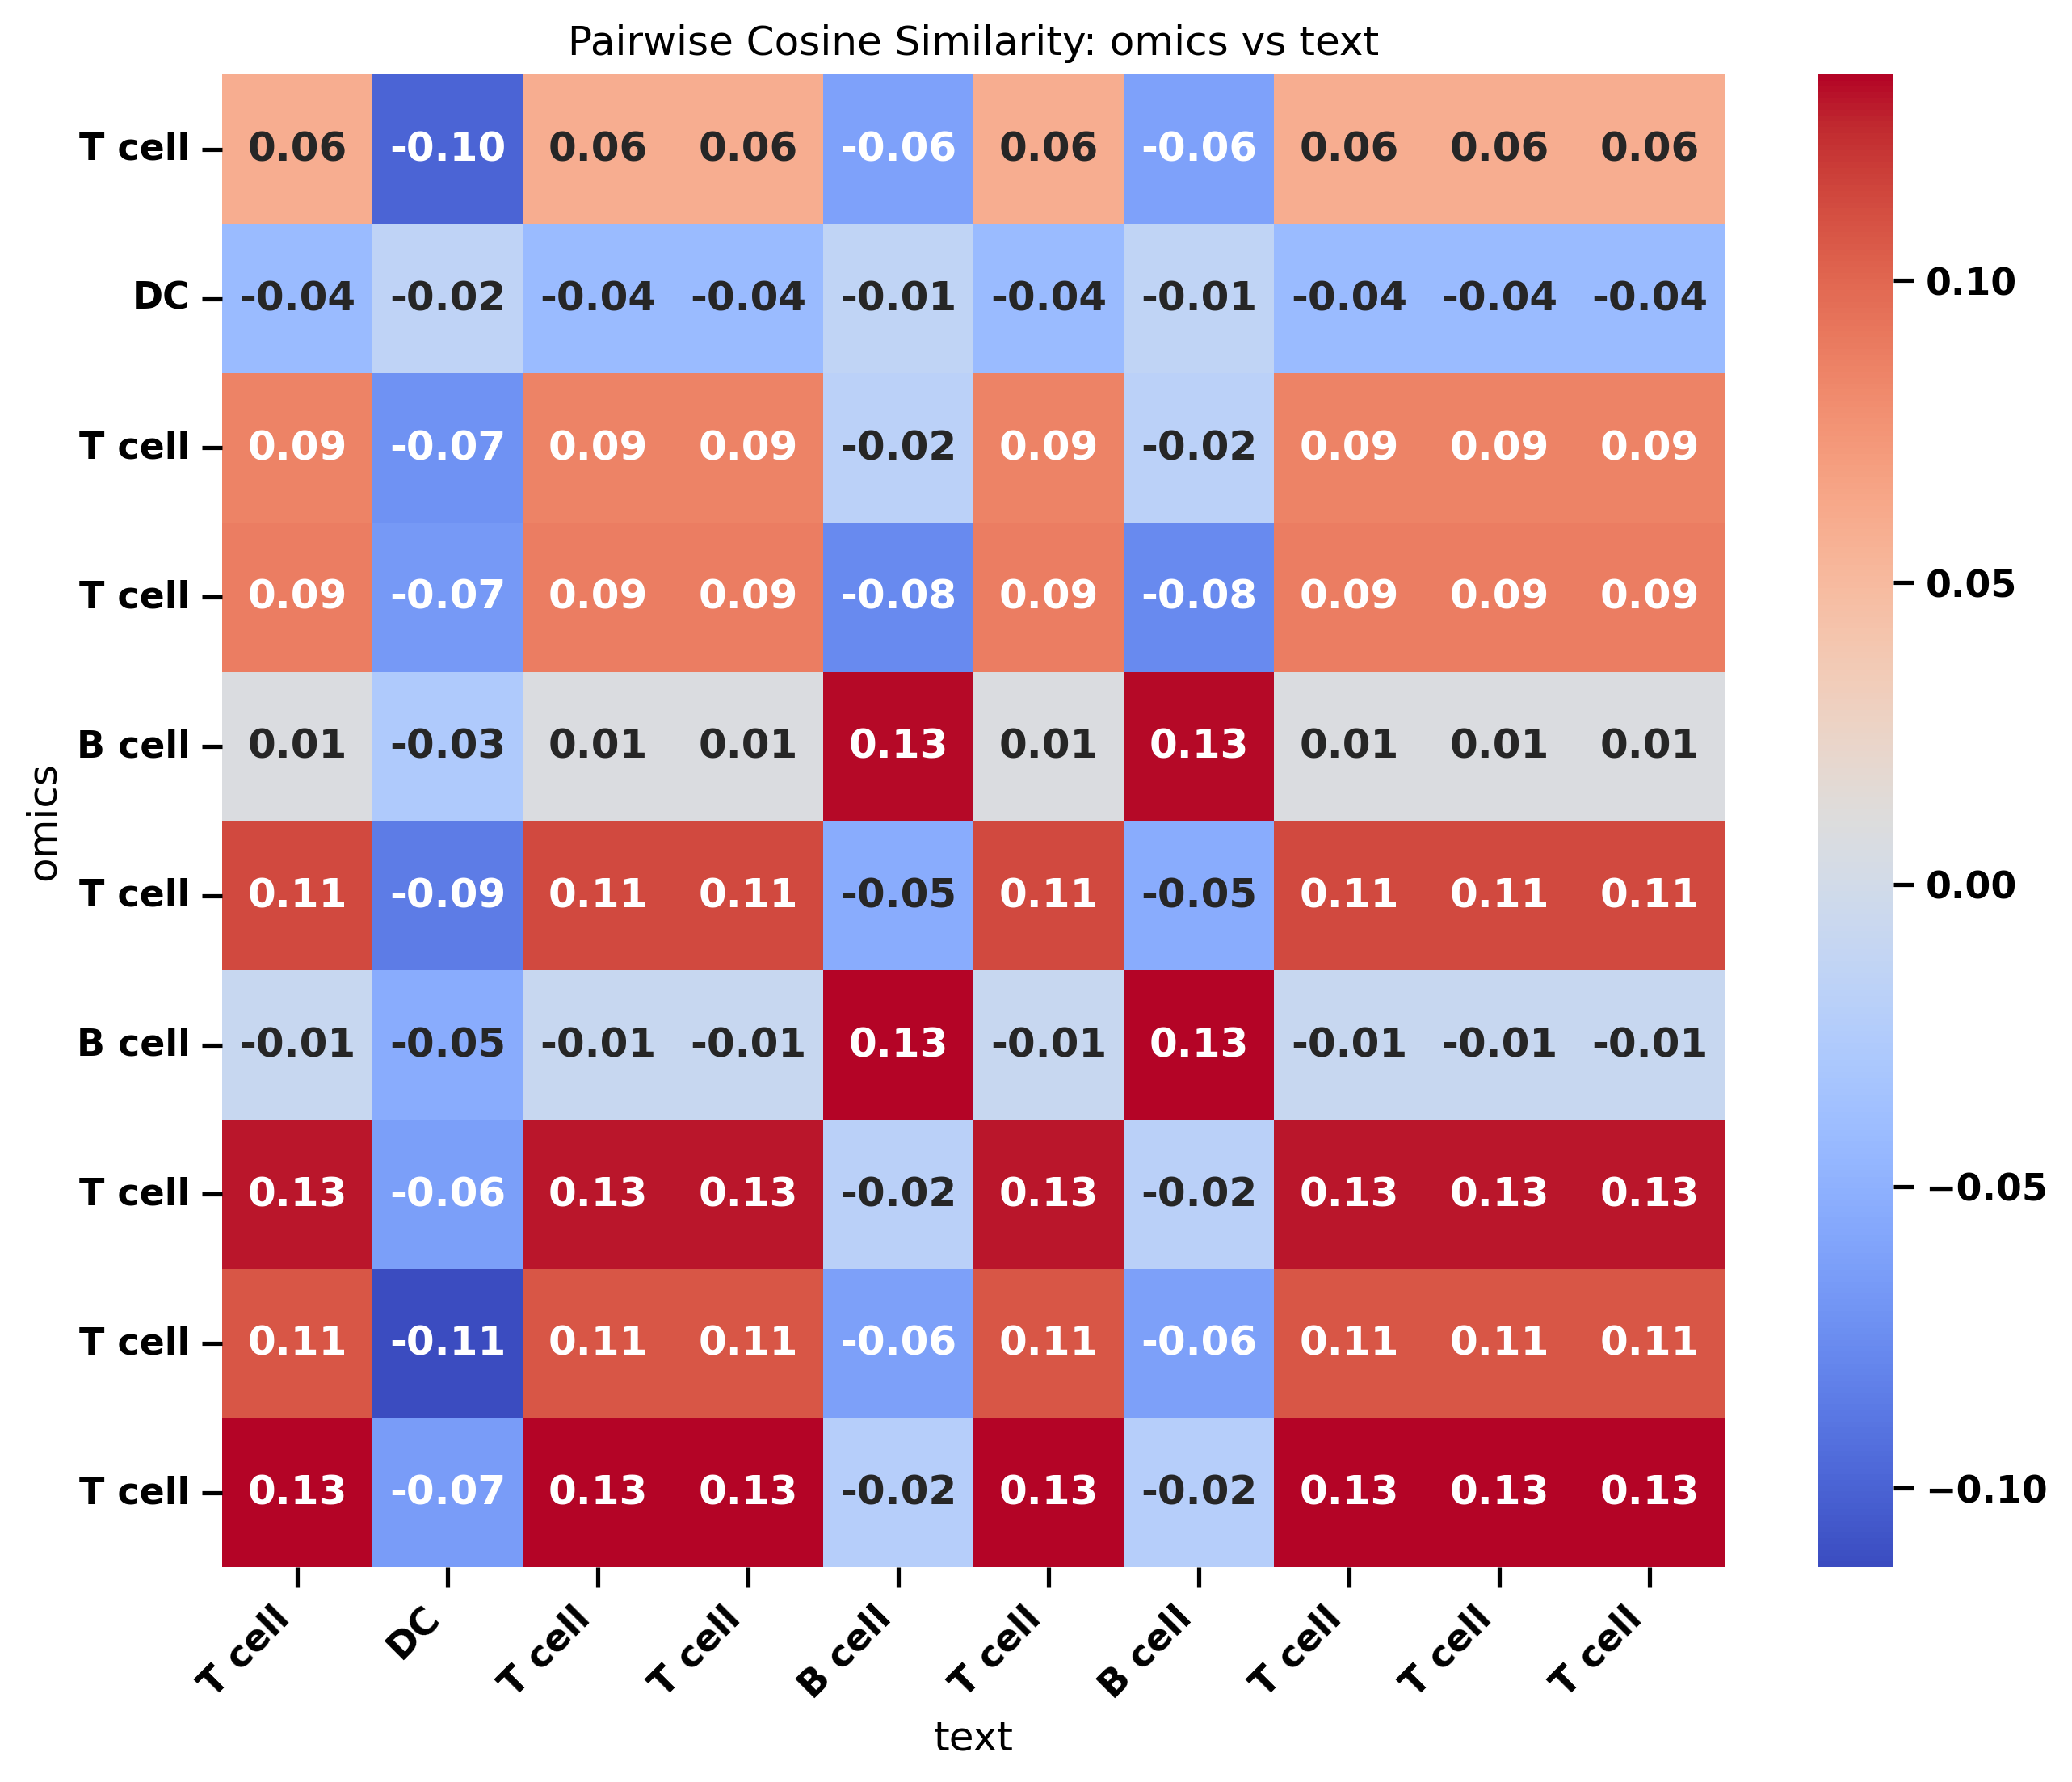

In [59]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", label_key=label_key)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


<Figure size 3000x2400 with 0 Axes>

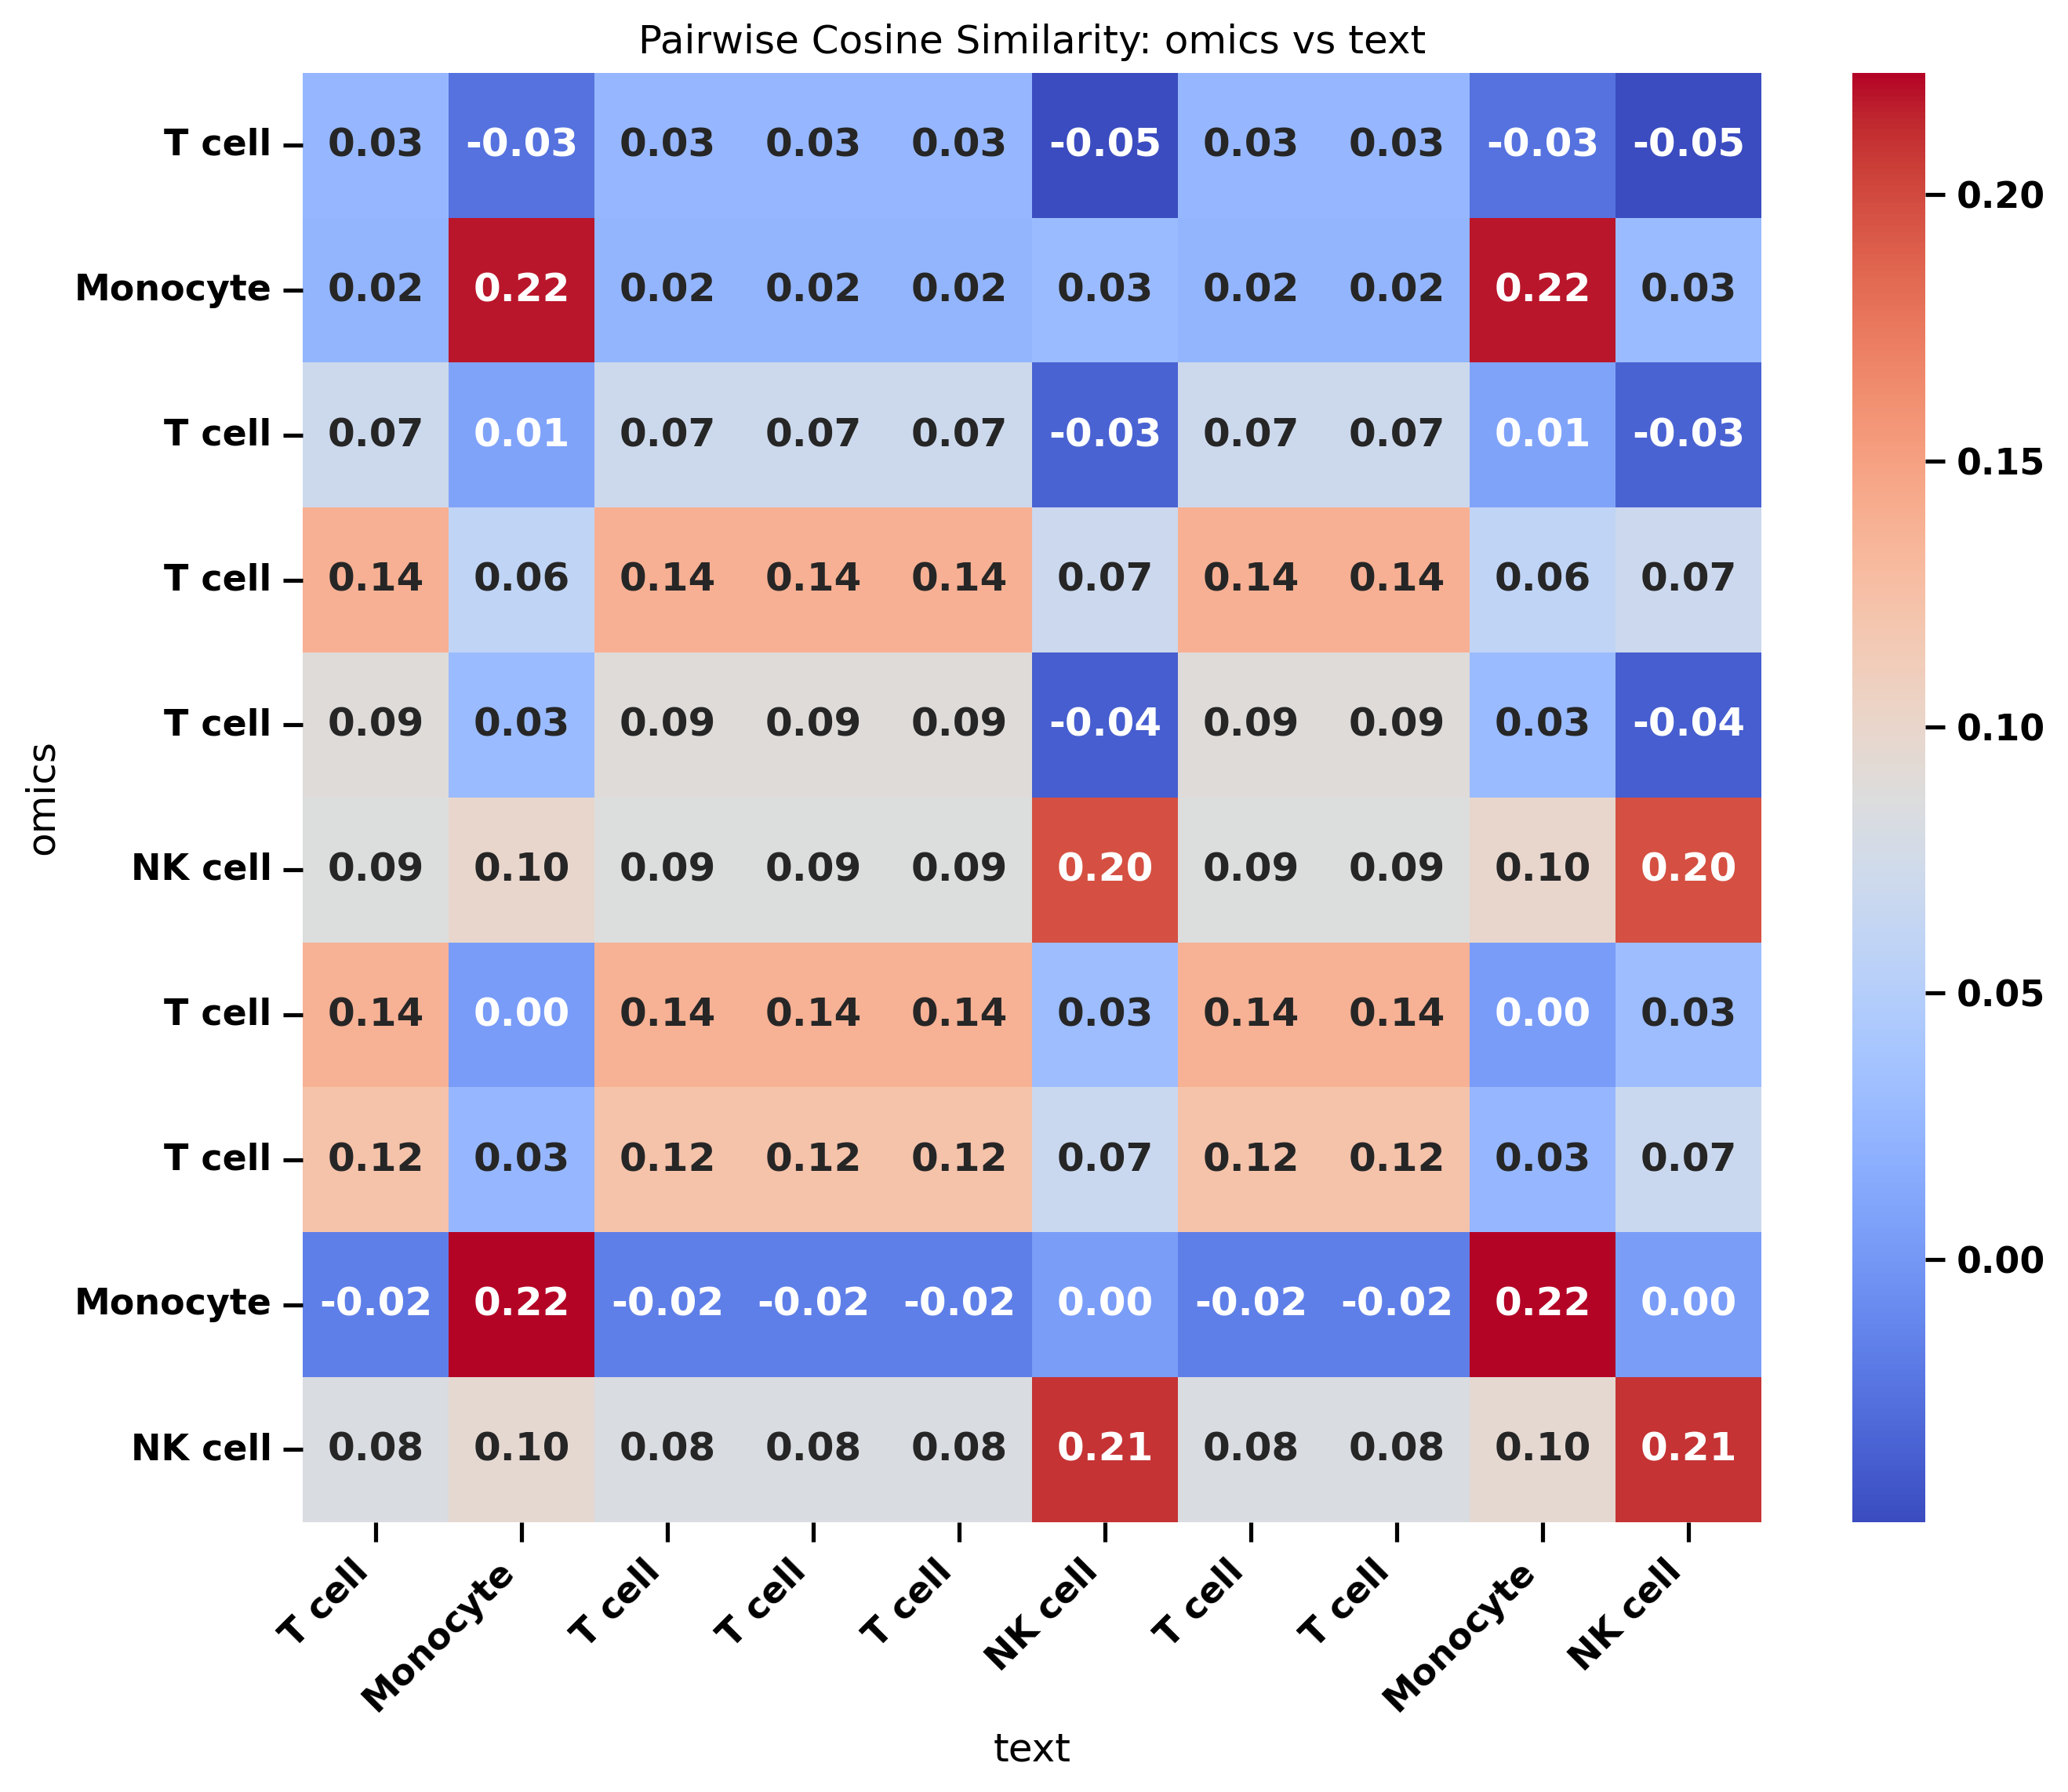

In [154]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", label_key=label_key)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


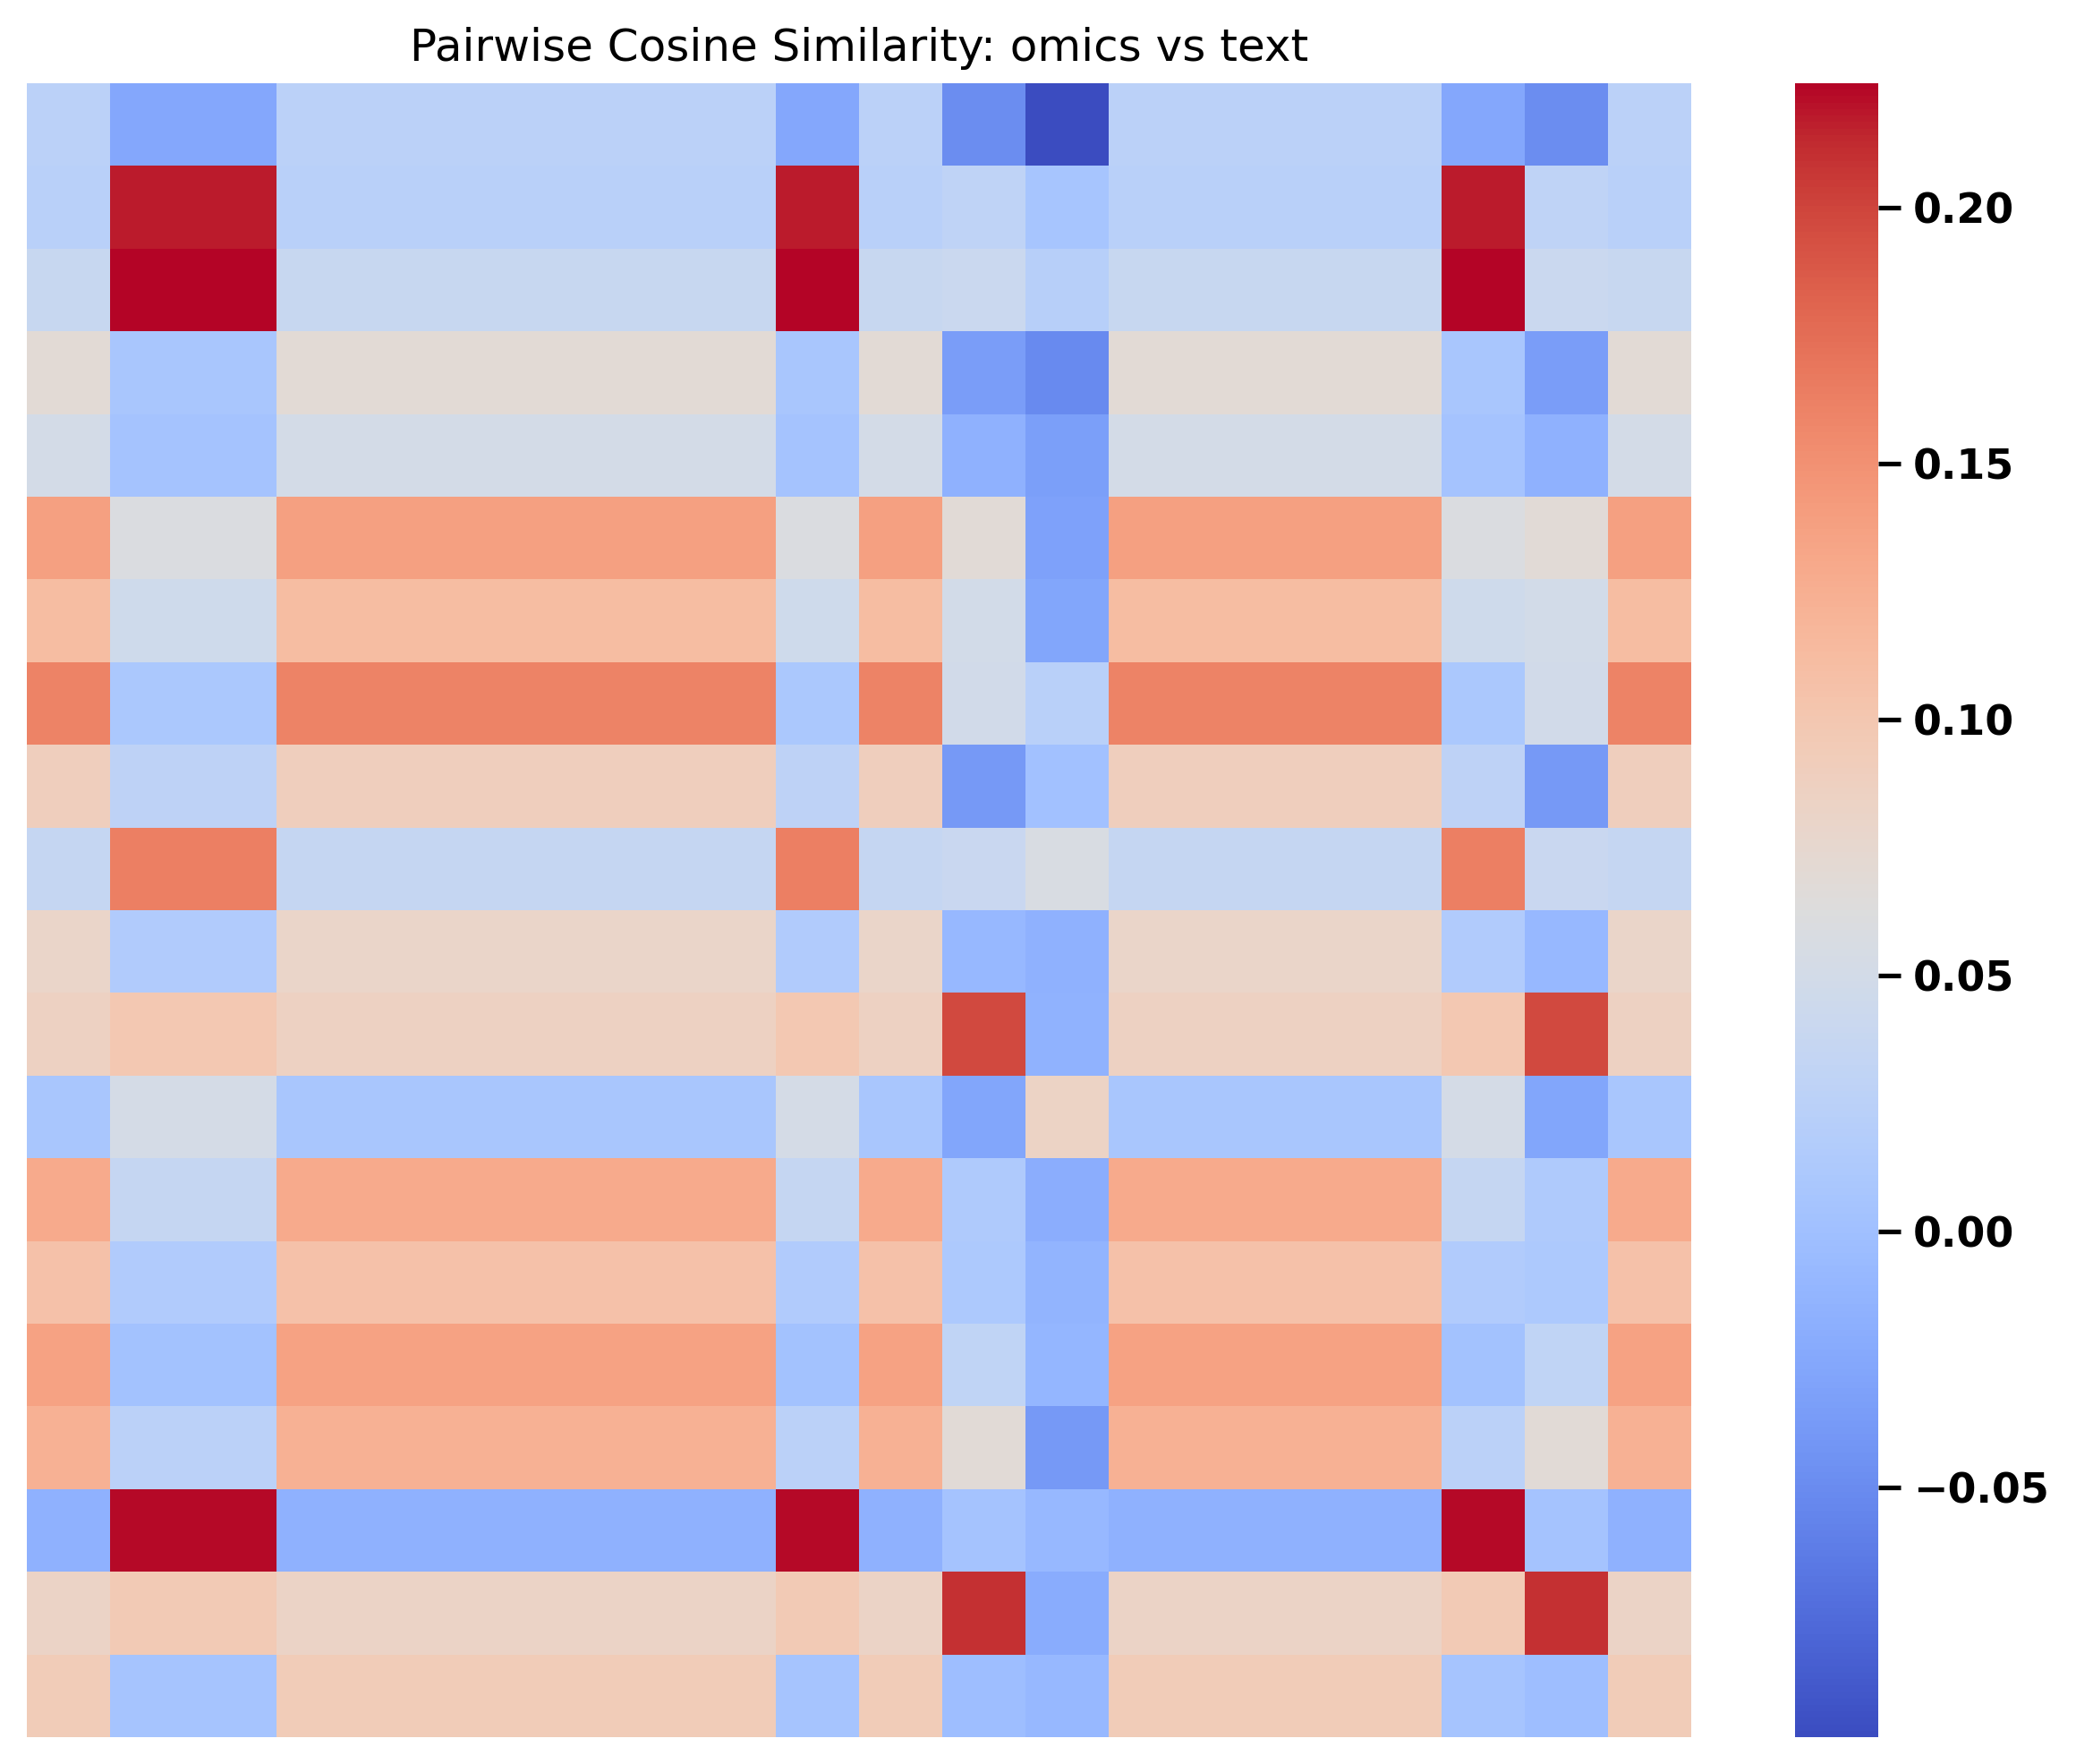

In [158]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=100)

In [1]:
from mmcontext.pp import remove_zero_variance_cells, remove_zero_variance_genes

adata = remove_zero_variance_cells(adata)
adata = remove_zero_variance_genes(adata)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'adata' is not defined

In [42]:
from mmcontext.eval import scibEvaluator

evalutator = scibEvaluator(
    adata=adata,
    batch_key="batch",
    label_key="cluster_lavel",
    embedding_key=["mmcontext_emb", "mmcontext_text_emb", "X_geneformer", "X_hvg", "X_pca", "X_scvi"],
    n_top_genes=5000,
    max_cells=5000,
)
res = evalutator.evaluate()

HVG


Error in data reduction: Bin edges must be unique: Index([               -inf,  -2.892823703725029, -0.6085385346302277,
       0.09924078048896734, 0.09924078048896734, 0.09924079373444396,
       0.14027225325936107, 0.18885910880786402, 0.23705809401106778,
          0.30732003013017,  0.4241397468442167,   0.611900446591554,
        0.9100024470921467,  1.3157359159517066,  1.9957290970961805,
         2.822801220996513,   3.787105232711744,    5.15218205363662,
         7.423641985710012,  100.20904103227615,                 inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
Using full data for metrics computation.


HVG
Cluster for cluster_0.2 with leiden


KeyError: 'No "neighbors" in .uns'